This based off of the tutorial from scanpy using pbmc 3K.
https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

And heavily influenced by https://github.com/theislab/scanpy_usage/blob/master/170503_zheng17/zheng17.ipynb

We are interesting in doing 1month vs 30month, male kidney

In [23]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
from matplotlib.pyplot import rc_context



import os

# import the SC_preprocessing code
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')

from buddi import buddi
from buddi.preprocessing import sc_preprocess
from buddi.plotting import validation_plotting as vp


sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')


scanpy==1.8.2 anndata==0.8.0 umap==0.5.2 numpy==1.23.5 scipy==1.8.1 pandas==1.5.3 scikit-learn==1.3.1 statsmodels==0.14.0 python-igraph==0.10.8 pynndescent==0.5.10


## Open files

In [24]:
data_path = f"{os.getcwd()}/../../data/bulk_data/l1000/"
sc_aug_data_path = f"{os.getcwd()}/../../data/bulk_data/augmented_l1000_data/"

# this data is downloaded from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM4150378
# I used the RDS files -- DO NOT USE THE OTHER FILE TYPES
# they have gene names that are off by 1
# I took the RDS files, then converted them to anndata using sceasy 

de_results_file = f"{data_path}/de_l1000_pseudobulk_results.pkl"

num_genes = 967

exp_id = "all-l1000"



In [25]:

# now get the sc ref training data

# read in order
# oritinal samples
curr_samp = 'samp_l1000'
stim_order = ['CTRL', "STIM"]

X_concat = None
Y_concat = None
meta_concat = None

for curr_stim in stim_order:

    print(curr_samp)
    pseudobulks_df, prop_df, gene_df, sig_df, metadata_df = sc_preprocess.read_single_pseudobulk_file(sc_aug_data_path, curr_samp, curr_stim, "Train", exp_id)
    pseudobulks_df.columns = gene_df

    if X_concat is None:
        X_concat, Y_concat, meta_concat = pseudobulks_df, prop_df, metadata_df
    else:
        X_concat = pd.concat([X_concat, pseudobulks_df])
        Y_concat = pd.concat([Y_concat, prop_df])
        meta_concat = pd.concat([meta_concat, metadata_df])

Y_concat.index = meta_concat.index
meta_concat = pd.concat([meta_concat, Y_concat], axis=1)


samp_l1000
samp_l1000


In [26]:
meta_concat

,sample_id,stim,isTraining,cell_prop_type,samp_type,A549,MCF7
0,samp_l1000,CTRL,Train,random,sc_ref,0.2,0.8
1,samp_l1000,CTRL,Train,random,sc_ref,0.9,0.1
2,samp_l1000,CTRL,Train,random,sc_ref,0.3,0.7
3,samp_l1000,CTRL,Train,random,sc_ref,0.3,0.7
4,samp_l1000,CTRL,Train,random,sc_ref,0.1,0.9
...,...,...,...,...,...,...,...
995,samp_l1000,STIM,Train,random,sc_ref,0.1,0.9
996,samp_l1000,STIM,Train,random,sc_ref,0.9,0.1
997,samp_l1000,STIM,Train,random,sc_ref,0.6,0.4
998,samp_l1000,STIM,Train,random,sc_ref,0.5,0.5


In [27]:
adata = ad.AnnData(X_concat)
adata.obs = meta_concat
adata.var = pd.DataFrame(gene_df)

/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [28]:
adata.obs

,sample_id,stim,isTraining,cell_prop_type,samp_type,A549,MCF7
0,samp_l1000,CTRL,Train,random,sc_ref,0.2,0.8
1,samp_l1000,CTRL,Train,random,sc_ref,0.9,0.1
2,samp_l1000,CTRL,Train,random,sc_ref,0.3,0.7
3,samp_l1000,CTRL,Train,random,sc_ref,0.3,0.7
4,samp_l1000,CTRL,Train,random,sc_ref,0.1,0.9
...,...,...,...,...,...,...,...
995,samp_l1000,STIM,Train,random,sc_ref,0.1,0.9
996,samp_l1000,STIM,Train,random,sc_ref,0.9,0.1
997,samp_l1000,STIM,Train,random,sc_ref,0.6,0.4
998,samp_l1000,STIM,Train,random,sc_ref,0.5,0.5


In [29]:

tab = adata.obs.groupby(['stim', 'cell_prop_type']).size()

tab.unstack()

cell_prop_type,random
stim,
CTRL,1000
STIM,1000


## Preprocessing

normalizing counts per cell
    finished (0:00:00)


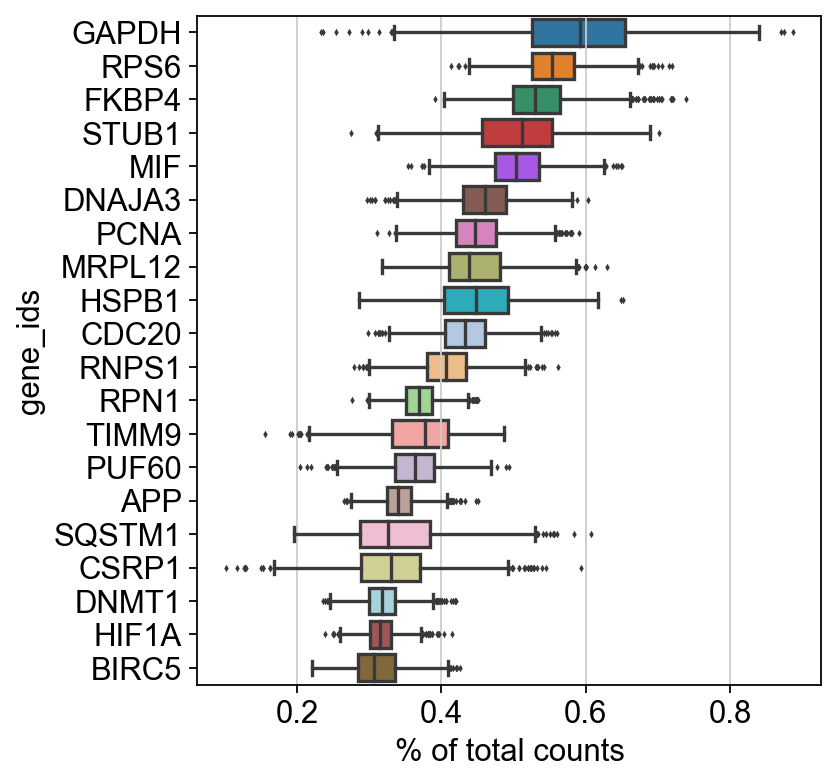

In [30]:
sc.pl.highest_expr_genes(adata, n_top=20, )


In [31]:
adata.var_names[np.where(adata.var_names.str.startswith('MT'))]

Index(['MTA1', 'MTFR1', 'MTHFD2', 'MTF2', 'MTERF3'], dtype='object', name='gene_ids')

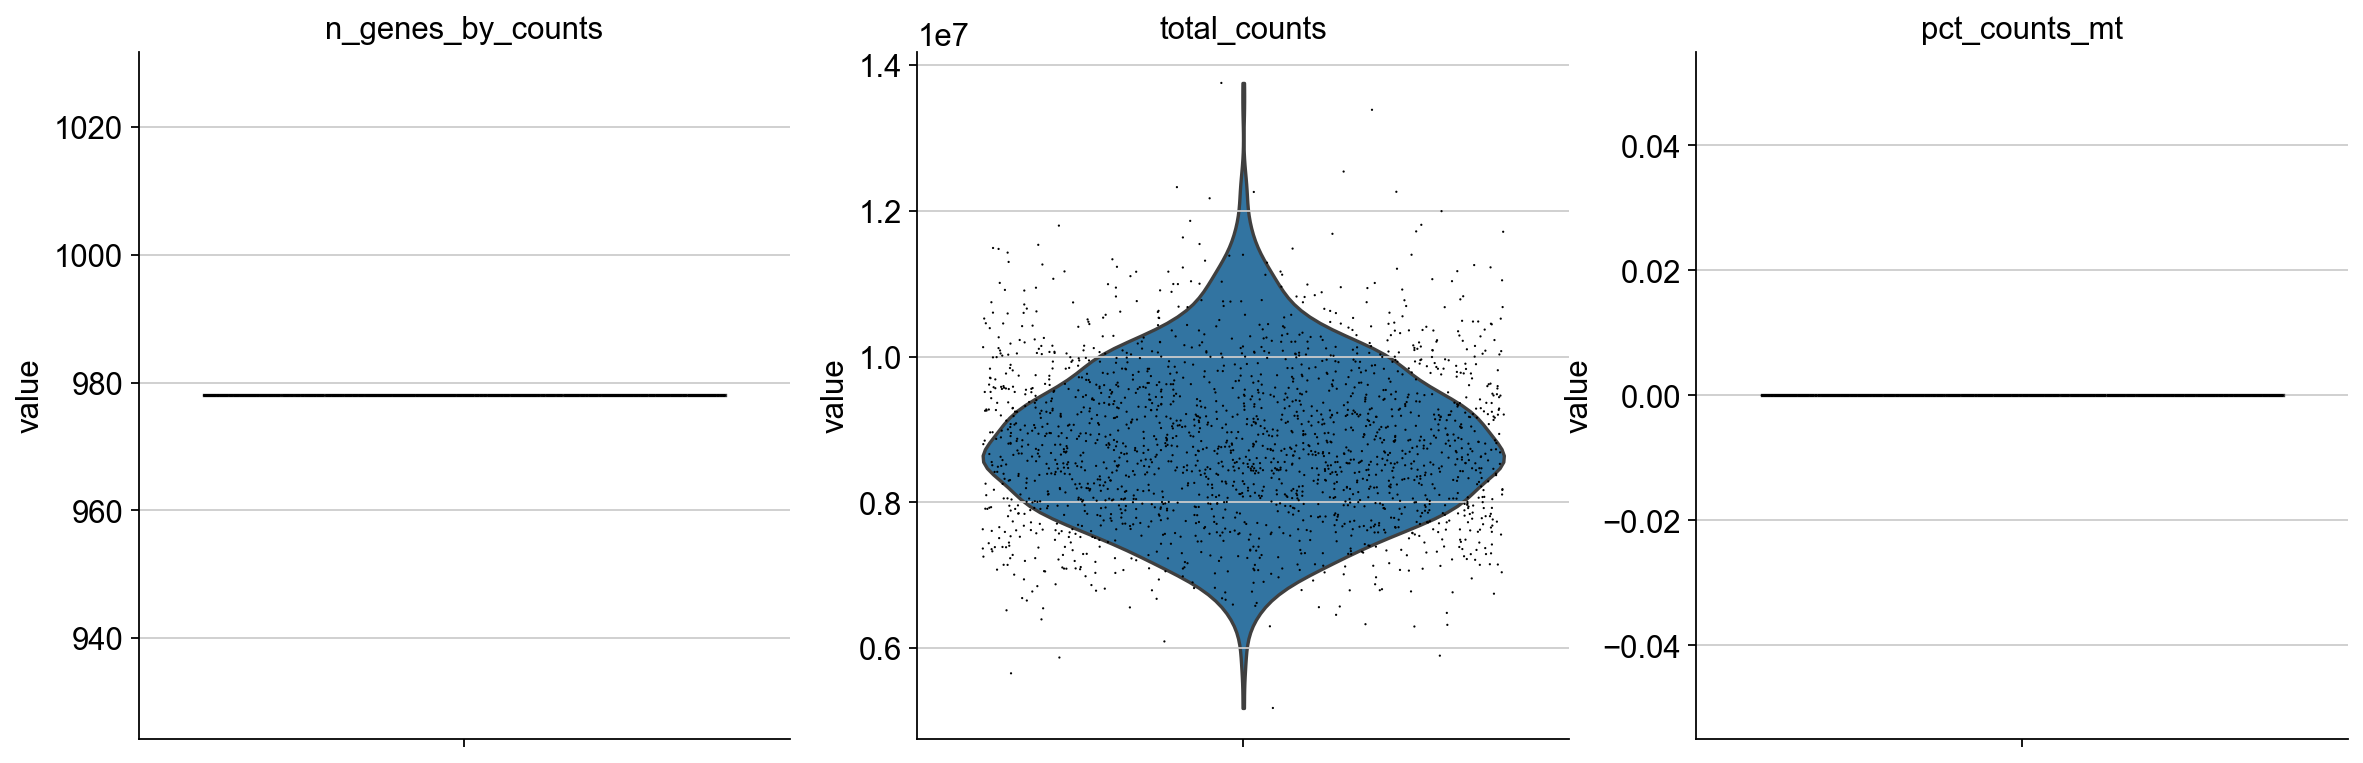

In [32]:
# remove genes with high mitochondrial content
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

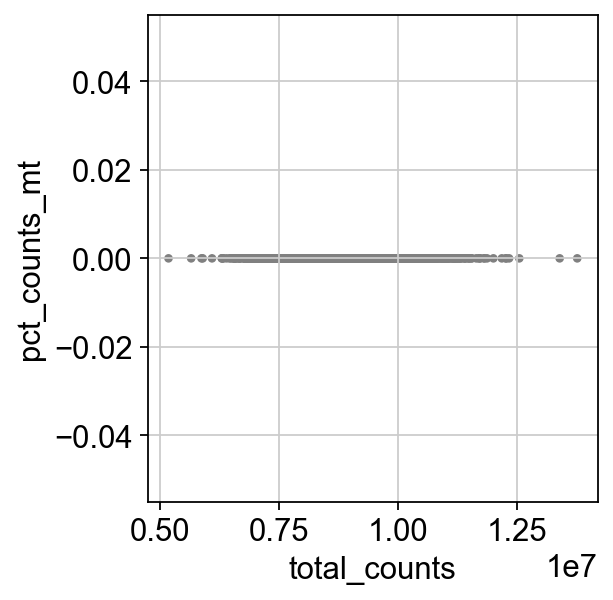

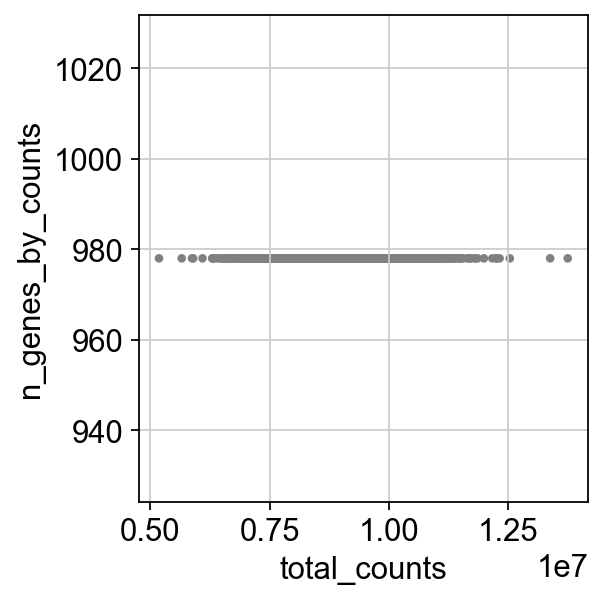

In [33]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

# DESeq

In [34]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [35]:
def get_pseudobulk_DE(meta_DESeq, expr_matr):

    # make it conform to DESeq reqr
    expr_matr = np.ceil(expr_matr)
    expr_matr = expr_matr+1

    de_cell = expr_matr
    meta_DESeq_cell = meta_DESeq

    # reindex so that anndata obj can be created easily
    new_index = ["samp_" + str(s) for s in range(de_cell.shape[0])]
    de_cell.index = new_index
    meta_DESeq_cell.index = new_index

    # filter out lowly expressed genes
    genes_to_keep = de_cell.columns[de_cell.mean(axis=0) > 1]
    de_cell = de_cell[genes_to_keep]    
    print(de_cell.shape)        

    # run deseq
    dds_cell = DeseqDataSet(
        counts=de_cell,
        clinical=meta_DESeq_cell,
        design_factors=["stim"],
        refit_cooks=True
    )

    print("running contrast")

    dds_cell.deseq2()
    cell_res = DeseqStats(dds_cell, contrast=["stim", "STIM", "CTRL"])
    cell_res.summary()

    # get the DESeq res matrix
    cell_res_df = cell_res.results_df

    # get the genes of interest
    cell_res_df_sig = cell_res_df.iloc[np.where(cell_res_df["padj"] < 0.01)[0]]
    cell_res_df_sig = cell_res_df_sig.iloc[np.argsort(np.abs(cell_res_df_sig["log2FoldChange"]))[::-1]]
    top_genes = cell_res_df_sig.index.to_list()

    return (top_genes, cell_res_df) 

In [36]:
adata.obs

,sample_id,stim,isTraining,cell_prop_type,samp_type,A549,MCF7,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
0,samp_l1000,CTRL,Train,random,sc_ref,0.2,0.8,978,7366799.0,0.0,0.0
1,samp_l1000,CTRL,Train,random,sc_ref,0.9,0.1,978,8599378.0,0.0,0.0
2,samp_l1000,CTRL,Train,random,sc_ref,0.3,0.7,978,9664932.0,0.0,0.0
3,samp_l1000,CTRL,Train,random,sc_ref,0.3,0.7,978,10618420.0,0.0,0.0
4,samp_l1000,CTRL,Train,random,sc_ref,0.1,0.9,978,10601827.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
995,samp_l1000,STIM,Train,random,sc_ref,0.1,0.9,978,10410883.0,0.0,0.0
996,samp_l1000,STIM,Train,random,sc_ref,0.9,0.1,978,9272922.0,0.0,0.0
997,samp_l1000,STIM,Train,random,sc_ref,0.6,0.4,978,7906430.0,0.0,0.0
998,samp_l1000,STIM,Train,random,sc_ref,0.5,0.5,978,9366640.0,0.0,0.0


In [37]:
expr_df = pd.DataFrame(adata.X)
expr_df.columns = adata.var["gene_ids"]
top_genes, cell_res_df = get_pseudobulk_DE(adata.obs, expr_df)


(2000, 978)
running contrast
Fitting size factors...
... done in 0.05 seconds.

Fitting dispersions...
... done in 0.86 seconds.

Fitting dispersion trend curve...
... done in 0.13 seconds.

Fitting MAP dispersions...
... done in 0.67 seconds.

Fitting LFCs...
... done in 3.59 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 2.21 seconds.

Log2 fold change & Wald test p-value: stim STIM vs CTRL


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_ids,,,,,,
AARS,15099.848952,0.064580,0.005912,10.923956,8.855277e-28,1.789351e-27
ABCF1,14208.855892,0.050835,0.006269,8.109006,5.103551e-16,8.503020e-16
ABL1,5393.158047,-0.185574,0.008880,-20.896918,5.711516e-97,2.659935e-96
ACAA1,5337.356923,0.170812,0.007765,21.997968,3.011736e-107,1.502795e-106
ACAT2,10042.572622,-0.054766,0.006286,-8.713027,2.958671e-18,5.148719e-18
...,...,...,...,...,...,...
TXLNA,16048.108848,-0.104615,0.007249,-14.431479,3.279701e-47,8.530713e-47
SPRED2,11820.013391,-0.002431,0.007625,-0.318831,7.498545e-01,7.655091e-01
EML3,6975.104672,0.015885,0.009362,1.696729,8.974789e-02,1.013550e-01


In [38]:
cell_res_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_ids,,,,,,
AARS,15099.848952,0.064580,0.005912,10.923956,8.855277e-28,1.789351e-27
ABCF1,14208.855892,0.050835,0.006269,8.109006,5.103551e-16,8.503020e-16
ABL1,5393.158047,-0.185574,0.008880,-20.896918,5.711516e-97,2.659935e-96
ACAA1,5337.356923,0.170812,0.007765,21.997968,3.011736e-107,1.502795e-106
ACAT2,10042.572622,-0.054766,0.006286,-8.713027,2.958671e-18,5.148719e-18
...,...,...,...,...,...,...
TXLNA,16048.108848,-0.104615,0.007249,-14.431479,3.279701e-47,8.530713e-47
SPRED2,11820.013391,-0.002431,0.007625,-0.318831,7.498545e-01,7.655091e-01
EML3,6975.104672,0.015885,0.009362,1.696729,8.974789e-02,1.013550e-01


In [39]:
cell_res_df_sig = cell_res_df.iloc[np.where(cell_res_df["padj"] < 0.0000001)[0]]
cell_res_df_sig = cell_res_df_sig.iloc[np.argsort(np.abs(cell_res_df_sig["log2FoldChange"]))[::-1]]

In [40]:
cell_res_df_sig

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_ids,,,,,,
ALDOC,5035.116678,1.076773,0.017020,63.264416,0.000000e+00,0.000000e+00
NOSIP,10958.953517,0.901378,0.015138,59.543731,0.000000e+00,0.000000e+00
FOSL1,4482.464384,-0.900508,0.018063,-49.853877,0.000000e+00,0.000000e+00
PLA2G15,6448.246402,0.892939,0.013983,63.858137,0.000000e+00,0.000000e+00
NPC1,5386.093280,0.808969,0.014791,54.693530,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...
OXSR1,4893.524915,-0.032110,0.005698,-5.634928,1.751311e-08,2.446832e-08
RPN1,32365.102714,-0.031624,0.004810,-6.574285,4.888765e-11,7.189793e-11
SDHB,23262.030116,0.027747,0.003888,7.137270,9.520263e-13,1.452546e-12


In [41]:
top_genes

['ALDOC',
 'NOSIP',
 'FOSL1',
 'PLA2G15',
 'NPC1',
 'FOXO4',
 'CCL2',
 'SMAD3',
 'MLLT11',
 'LGMN',
 'GRN',
 'DUSP4',
 'INSIG1',
 'EDN1',
 'ITGB5',
 'STXBP1',
 'HMGCS1',
 'DNAJB1',
 'NRIP1',
 'ATP6V1D',
 'HSPA1A',
 'FAM57A',
 'KEAP1',
 'LPGAT1',
 'TSKU',
 'SUV39H1',
 'RTN2',
 'SLC25A4',
 'HOXA10',
 'MYC',
 'IGFBP3',
 'PTGS2',
 'HIST1H2BK',
 'GNAI2',
 'DUSP14',
 'RAD9A',
 'SPR',
 'FBXO11',
 'FGFR4',
 'PAK1',
 'DDIT4',
 'SORBS3',
 'POLE2',
 'UGDH',
 'KCTD5',
 'PTPN1',
 'XPO7',
 'CBR3',
 'SPAG7',
 'LRPAP1',
 'VAT1',
 'FOS',
 'PLK1',
 'RHOA',
 'GADD45B',
 'PPARG',
 'CRYZ',
 'TCERG1',
 'SNCA',
 'ADGRE5',
 'HMGA2',
 'TPM1',
 'MAN2B1',
 'PSMB8',
 'POLB',
 'ZFP36',
 'EGFR',
 'CORO1A',
 'TSEN2',
 'GNA11',
 'PGM1',
 'GTPBP8',
 'MAP4K4',
 'RPIA',
 'DNAJB2',
 'DCTD',
 'HOXA5',
 'SRC',
 'FDFT1',
 'CLIC4',
 'SPTAN1',
 'CCNA2',
 'HIST2H2BE',
 'PRSS23',
 'WDTC1',
 'CXCL2',
 'PIH1D1',
 'PRAF2',
 'HSD17B11',
 'NFIL3',
 'PTPN12',
 'KIAA1033',
 'USP22',
 'NUP62',
 'UBE2C',
 'CTSL',
 'GRB10',
 'BHLHE40',
 

In [42]:

all_res_df = {}

all_res_df["pseudobulk"] = cell_res_df
    

In [43]:
de_results_file

'/Users/davidnat/Documents/projects/greenelab/buddi_test/buddi_analysis/sc_preprocessing/0_qc_notebooks/../../data/bulk_data/l1000//de_l1000_pseudobulk_results.pkl'

In [44]:
import pickle

print("write")        

pickle.dump( all_res_df, open( de_results_file, "wb" ) )



write
